## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install mpl_scatter_density
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import glob
from pyliftover import LiftOver
# from multiprocessing import Pool, cpu_count
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = data_path + 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = data_path + 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'
constraint_file_path = data_path + 'gnomad.v4.0.constraint_metrics.tsv'
domain_file_path = data_path + 'uniprotdomains.gz'
gene_domain_file_path = data_path + 'chr2_gene_domain_combinations.tsv.gz'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'
bipex_variants_file_path = data_path + 'BipEx_variant_results.tsv.bgz'
aou_variants_file_path = data_path + 'aou_variants.tsv.gz'
genome_coverage_file_path = data_path + 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'
ukb_variants_file_path = data_path + 'ukb24310_c19.qced_nonrel.vmiss.gz'

## Define helper methods

In [3]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[coverage_mask])
    
    positions = np.where(coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')
    
    print(cases_df)

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])
    print(unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand'))
    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1
        

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Load data

In [4]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [8]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


In [5]:
# Read the data into a DataFrame
bipex_variant_results_df = pd.read_csv(bipex_variants_file_path, sep='\t', compression='gzip')

# Split locus into chr and pos and convert to integers
bipex_variant_results_df[['chr', 'pos']] = bipex_variant_results_df['locus'].str.split(':', expand=True)
bipex_variant_results_df['pos'] = bipex_variant_results_df['pos'].astype(int)

# Filter out rows
bipex_variant_results_df = bipex_variant_results_df[(bipex_variant_results_df['chr'] != "chrX") & (bipex_variant_results_df['chr'] != "chrY") & (bipex_variant_results_df['chr'] != "chrMT")]

filter_consequence_list = [
    "synonymous",
    "non_coding",
    "NA"
]

# Filter rows
bipex_variant_results_df = bipex_variant_results_df[~bipex_variant_results_df['consequence'].isin(filter_consequence_list)]
bipex_variant_results_df = bipex_variant_results_df[~bipex_variant_results_df['consequence'].isna()]

# Add gene names
bipex_variant_results_df = pd.merge(bipex_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

bipex_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,cadd,mpc,polyphen,group,...,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,in_gnomad_non_neuro,chr,pos,gene_name
0,chr1:925922,"[""G"",""A""]",ENSG00000187634,other_missense,c.-20G>A,NaN,22.30,NaN,NaN,Bipolar Disorder,...,0,28844,NaN,NaN,NaN,True,False,chr1,925922,SAMD11
1,chr1:925922,"[""G"",""A""]",ENSG00000187634,other_missense,c.-20G>A,NaN,22.30,NaN,NaN,Bipolar Disorder (including Schizoaffective),...,0,28844,NaN,NaN,NaN,True,False,chr1,925922,SAMD11
2,chr1:925922,"[""G"",""A""]",ENSG00000187634,other_missense,c.-20G>A,NaN,22.30,NaN,NaN,Bipolar Disorder 1,...,0,28844,NaN,NaN,NaN,True,False,chr1,925922,SAMD11
3,chr1:925923,"[""G"",""C""]",ENSG00000187634,other_missense,c.-19G>C,NaN,20.20,NaN,NaN,Bipolar Disorder,...,1,28844,NaN,NaN,NaN,True,False,chr1,925923,SAMD11
4,chr1:925923,"[""G"",""C""]",ENSG00000187634,other_missense,c.-19G>C,NaN,20.20,NaN,NaN,Bipolar Disorder (including Schizoaffective),...,1,28844,NaN,NaN,NaN,True,False,chr1,925923,SAMD11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867259,chr22:50782243,"[""C"",""T""]",ENSG00000079974,other_missense,c.52G>A,p.Ala18Thr,18.69,NaN,benign,Bipolar Disorder with Psychosis,...,15,28844,0.31788,0.43477,0.50966,False,True,chr22,50782243,RABL2B
9867260,chr22:50782243,"[""C"",""T""]",ENSG00000079974,other_missense,c.52G>A,p.Ala18Thr,18.69,NaN,benign,Bipolar Disorder without Psychosis,...,15,28844,0.38228,0.45574,0.49962,False,True,chr22,50782243,RABL2B
9867261,chr22:50782290,"[""G"",""C""]",ENSG00000079974,other_missense,c.5C>G,p.Ala2Gly,24.10,NaN,possibly_damaging,Bipolar Disorder,...,0,28844,NaN,NaN,NaN,True,False,chr22,50782290,RABL2B
9867262,chr22:50782290,"[""G"",""C""]",ENSG00000079974,other_missense,c.5C>G,p.Ala2Gly,24.10,NaN,possibly_damaging,Bipolar Disorder (including Schizoaffective),...,0,28844,NaN,NaN,NaN,True,False,chr22,50782290,RABL2B


In [9]:
# Define path to predictions file
rgc_predictions_file_path = results_path + 'HMM_rgc_0.9_over20_chr2_predictions_rgc_wgs.tsv.gz'

# Load in saved predictions for rgc dataset
predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Bipolar pLoF Analysis using Fisher's Exact Test

In [6]:
# Parameters for analysis
prob_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = bipex_variant_results_df

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]
    
    # Subset analysis to pLoFs
    cases_df = chr_variant_results_df[chr_variant_results_df['consequence'] == 'ptv']
    
    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)
        
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(results_path + 'bipex_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

significant_genes_df

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1
                  locus     alleles          gene_id consequence      hgvsc  \
93          chr1:930221   ["C","T"]  ENSG00000187634         ptv   c.139C>T   
94          chr1:930221   ["C","T"]  ENSG00000187634         ptv   c.139C>T   
95          chr1:930221   ["C","T"]  ENSG00000187634         ptv   c.139C>T   
323         chr1:939069  ["T","TC"]  ENSG00000187634         ptv   c.466dup   
324         chr1:939069  ["T","TC"]  ENSG00000187634         ptv   c.466dup   
...                 ...         ...              ...         ...        ...   
1031065  chr1:248918016   ["C","T"]  ENSG00000185220         ptv  c.1432C>T   
1031066  chr1:248918016   ["C","T"]  ENSG00000185220         ptv  c.1432C>T   
1031067  chr1:248918016   ["C","T"]  ENSG00000185220         ptv  c.1432C>T   
1031068  chr1:248918016   ["C","T"]  ENSG00000185220         ptv  c.1432C>T   
103106

                0         1
1031179  6.211701  0.065825
1031180  6.090589  0.068319
1031181  5.252777  0.139782
1031182  8.371843  0.097239
1031183  6.555151  0.138432
...           ...       ...
1757057  0.338617  0.625034
1757058  0.583814  1.000000
1757059  0.000000  1.000000
1757060  1.091842  1.000000
1757061  0.000000  1.000000

[6937 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 3
                  locus    alleles          gene_id consequence       hgvsc  \
1757800     chr3:366021  ["G","T"]  ENSG00000134121         ptv   c.1657G>T   
1757801     chr3:366021  ["G","T"]  ENSG00000134121         ptv   c.1657G>T   
1757802     chr3:366021  ["G","T"]  ENSG00000134121         ptv   c.1657G>T   
1757803     chr3:366021  ["G","T"]  ENSG00000134121   

                0         1
2318652  1.863453  0.294225
2318653  1.827116  0.298258
2318654  1.674253  0.626695
2318655  1.965061  0.232321
2318656  0.756631  1.000000
...           ...       ...
2691555  1.014921  1.000000
2691556  0.583531  1.000000
2691557  1.395105  0.575595
2691558  0.000000  1.000000
2691559  2.522610  0.281368

[3964 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 5
                  locus      alleles          gene_id consequence  \
2691898     chr5:140464    ["C","T"]  ENSG00000153404         ptv   
2691899     chr5:140464    ["C","T"]  ENSG00000153404         ptv   
2691900     chr5:140464    ["C","T"]  ENSG00000153404         ptv   
2691998     chr5:140676  ["CTG","C"]  ENSG00000153404         ptv   
2691999     chr5:140676  

                0         1
3125991  0.646872  0.581758
3125992  0.634260  0.581149
3125993  0.656438  0.756122
3125994  1.046299  1.000000
3125995  0.818460  1.000000
...           ...       ...
3615939  2.029911  0.622237
3615940  8.374564  0.014855
3615941  7.570079  0.019895
3616006  1.750759  0.625087
3616008  4.912342  0.087325

[5648 rows x 2 columns]
                 gene_id gene_name  \
3210271  ENSG00000234127    TRIM26   
3417042  ENSG00000083097     DOP1A   
3417043  ENSG00000083097     DOP1A   

                                                group  total_ac_case  \
3210271               Bipolar Disorder with Psychosis             12   
3417042                              Bipolar Disorder             17   
3417043  Bipolar Disorder (including Schizoaffective)             17   

         total_an_case  total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
3210271           8810              3          28844   13.112526  0.000006  
3417042          27866              1      

                0         1
4102980  0.665311  0.406398
4102981  0.652338  0.405077
4102982  0.875281  1.000000
4102983  0.440379  0.405161
4102984  1.169384  0.786792
...           ...       ...
4459516  3.044973  0.371326
4459552  3.501639  0.300399
4459553  6.549273  0.138605
4459575  0.000000  1.000000
4459577  0.000000  1.000000

[3610 rows x 2 columns]
                 gene_id gene_name               group  total_ac_case  \
4335222  ENSG00000174417      TRHR  Bipolar Disorder 2             13   
4309630  ENSG00000175305     CCNE2  Bipolar Disorder 2              7   

         total_an_case  total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
4335222           6892              6          28844    9.083055  0.000004  
4309630           6892              0          28838         inf  0.000010  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 9
                  locus                                        

                0         1
4882027  1.863453  0.294225
4882028  2.030201  0.206841
4882029  1.050410  1.000000
4882030  3.349477  0.076477
4882031  1.309673  0.669063
...           ...       ...
5264169  0.676590  1.000000
5264170  0.583531  1.000000
5264171  0.000000  0.603567
5264172  0.000000  0.346925
5264173  0.630504  1.000000

[3979 rows x 2 columns]
                 gene_id gene_name  \
4933872  ENSG00000223601     EBLN1   
4933871  ENSG00000223601     EBLN1   
4903026  ENSG00000165632      TAF3   

                                                group  total_ac_case  \
4933872  Bipolar Disorder (including Schizoaffective)              3   
4933871                              Bipolar Disorder              3   
4903026                            Bipolar Disorder 2              8   

         total_an_case  total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
4933872          28420             24          28844    0.126773  0.000050  
4933871          27866             24      

                0         1
5894905  0.000000  0.500140
5894906  0.000000  0.500019
5894907  0.000000  0.537228
5894908  0.000000  1.000000
5894909  0.000000  1.000000
...           ...       ...
6397978  0.338283  0.625028
6397979  0.583531  1.000000
6397980  0.000000  1.000000
6397981  0.000000  1.000000
6397982  0.000000  1.000000

[5785 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 13
                   locus        alleles          gene_id consequence  \
6398413   chr13:19173992      ["G","C"]  ENSG00000198033         ptv   
6398414   chr13:19173992      ["G","C"]  ENSG00000198033         ptv   
6398415   chr13:19173992      ["G","C"]  ENSG00000198033         ptv   
6398416   chr13:19173992      ["G","C"]  ENSG00000198033         ptv   
6398417  

                0         1
6563321  1.811623  0.380042
6563322  1.776300  0.384206
6563323  2.188695  0.300570
6563324  1.871682  0.296786
6563379  1.621666  0.445473
...           ...       ...
6901410  0.000000  0.062523
6901411  0.000000  0.166346
6901412  0.000000  0.590703
6901413  0.000000  0.597156
6901414  0.000000  0.590886

[3976 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 15
                   locus    alleles          gene_id consequence       hgvsc  \
6901777   chr15:19964670  ["T","A"]  ENSG00000188403         ptv    c.349A>T   
6901778   chr15:19964670  ["T","A"]  ENSG00000188403         ptv    c.349A>T   
6901779   chr15:19964670  ["T","A"]  ENSG00000188403         ptv    c.349A>T   
6901780   chr15:19964670  ["T","A"]  ENSG00000188

                0         1
7255868       inf  0.491359
7255869       inf  0.496280
7255870       inf  0.233944
7255962  0.776298  1.000000
7255963  0.761164  1.000000
...           ...       ...
7760404  1.080969  1.000000
7760900       inf  0.491377
7760901       inf  0.496298
7760902       inf  0.363548
7760903       inf  0.233972

[4768 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 17
                  locus        alleles          gene_id consequence  \
7761050    chr17:162120  ["TAGTA","T"]  ENSG00000272636         ptv   
7761051    chr17:162120  ["TAGTA","T"]  ENSG00000272636         ptv   
7761052    chr17:162120  ["TAGTA","T"]  ENSG00000272636         ptv   
7761053    chr17:162120  ["TAGTA","T"]  ENSG00000272636         ptv   
7761111    chr

                0         1
8361982  0.689909  0.312882
8361983  0.676453  0.310823
8361984  0.666759  0.440214
8361985  0.380198  0.135562
8361986  0.818357  0.841568
...           ...       ...
8509260  1.691653  0.504630
8509261  1.751303  0.674668
8509288  1.395105  0.575595
8509289  1.091346  1.000000
8509290  0.000000  1.000000

[1532 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 19
                  locus     alleles          gene_id consequence       hgvsc  \
8509591    chr19:107557   ["T","C"]  ENSG00000176695         ptv  c.-55+2T>C   
8509592    chr19:107557   ["T","C"]  ENSG00000176695         ptv  c.-55+2T>C   
8509593    chr19:107557   ["T","C"]  ENSG00000176695         ptv  c.-55+2T>C   
8509594    chr19:107557   ["T","C"]  ENSG00000176

                0         1
9267829  1.035103  1.000000
9267830  1.014922  1.000000
9267831  1.050410  1.000000
9267835  0.837005  1.000000
9267836  0.654762  1.000000
...           ...       ...
9519128  0.202956  0.218803
9519129  0.350094  0.426924
9519130  0.000000  0.590703
9519131  0.654762  1.000000
9519132  0.000000  0.590886

[2826 rows x 2 columns]
                 gene_id gene_name                               group  \
9310729  ENSG00000101349      PAK5  Bipolar Disorder without Psychosis   
9310728  ENSG00000101349      PAK5                  Bipolar Disorder 2   

         total_ac_case  total_an_case  total_ac_ctrl  total_an_ctrl  \
9310729             12           7624              0          28844   
9310728              6           6892              0          28844   

         odds_ratio       p_value  
9310729         inf  6.922705e-09  
9310728         inf  5.136565e-05  
----------------------------------------------------------------------------------------------

                0         1
9623405  0.729363  0.623593
9623406  1.308080  0.581378
9623407  0.818440  1.000000
9623408  0.945801  1.000000
9623550  0.724498  0.629889
...           ...       ...
9866976  0.000000  0.130316
9866977  0.756599  1.000000
9866984  0.000000  0.003946
9866985  0.000000  0.003912
9866986  0.000000  0.031218

[2617 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []


,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
0,ENSG00000146463,ZMYM4,Bipolar Disorder without Psychosis,7,7624,2,28844,13.252855,0.000419
1,ENSG00000116830,TTF2,Bipolar Disorder 2,14,6892,17,28844,3.451568,0.000920
2,ENSG00000198691,ABCA4,Bipolar Disorder 2,14,6892,17,28844,3.451568,0.000920
3,ENSG00000146463,ZMYM4,Bipolar Disorder 2,6,6892,2,28844,12.565495,0.001003
4,ENSG00000160716,CHRNB2,Bipolar Disorder,19,27866,4,28844,4.919381,0.001318
...,...,...,...,...,...,...,...,...,...
103906,ENSG00000100109,TFIP11,Bipolar Disorder without Psychosis,4,7624,16,28844,0.945801,1.000000
103907,ENSG00000183597,TANGO2,Bipolar Disorder with Psychosis,0,8808,2,28834,0.000000,1.000000
103908,ENSG00000198792,TMEM184B,Bipolar Disorder without Psychosis,0,7624,2,28844,0.000000,1.000000
103909,ENSG00000100196,KDELR3,Bipolar Disorder,8,27866,9,28844,0.920063,1.000000


In [38]:
# # Parameters for analysis
# prob_thr = 0.6
# cnt_thr = 5
# significance_thr = 1
# variant_results_df = bipex_variant_results_df
# variant_results_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
#                                         (variant_results_df['an_case'] > 0) & 
#                                         (variant_results_df['an_ctrl'] > 0)]

# # Subset analysis to pLoFs
# cases_df = variant_results_df[variant_results_df['consequence'] == 'ptv']

# # Apply fishers exact test to get signicance scores from cases data
# tested_df = apply_fishers_exact_test(cases_df)

# # Filter rows where p_value < significance threshold and append these rows to the DataFrame
# significant_genes_df = tested_df[tested_df['p_value'] <= significance_thr]

# # Display the sorted DataFrame
# # print(tested_df[tested_df['p_value'] < .0001])
    
# # Write significant_genes_df to a csv to avoid recomputing
# # significant_genes_df.to_csv(results_path + 'bipex_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

# significant_genes_df #[significant_genes_df['p_value'] < .0001]

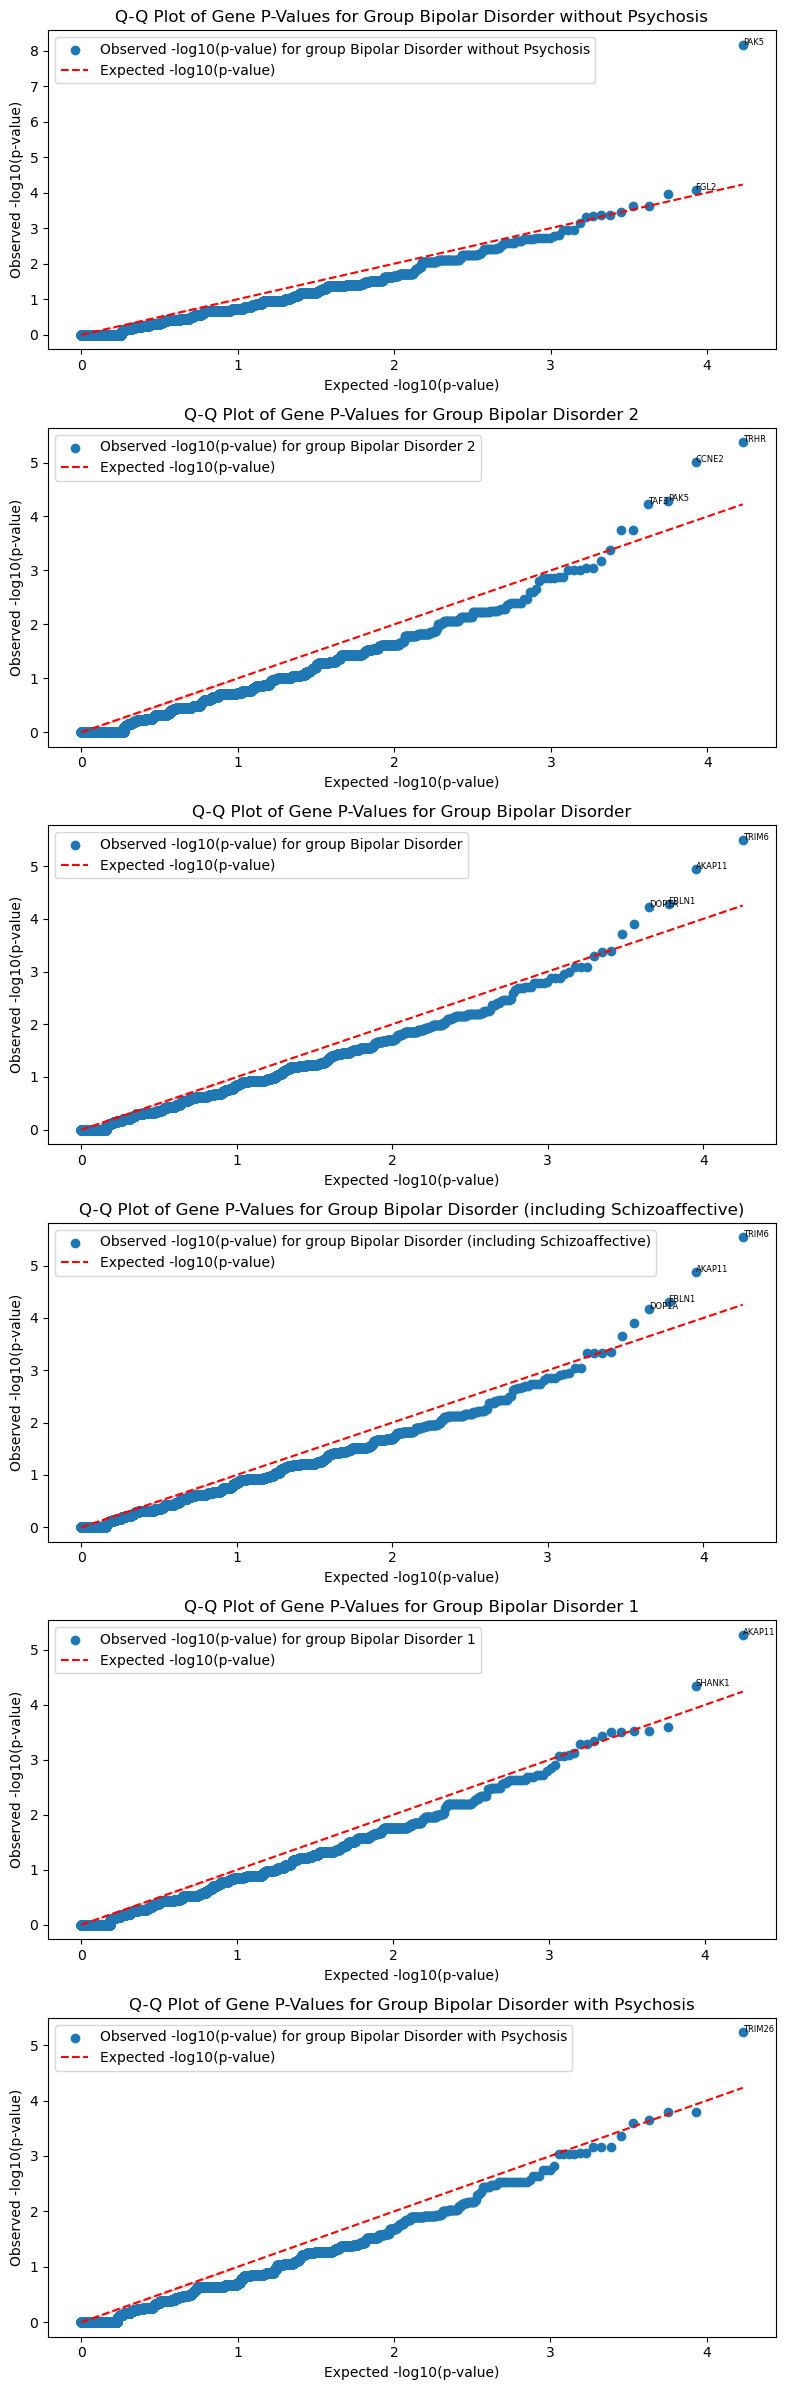

In [7]:
plot_group_QQ(significant_genes_df)

## Combine RGC constraint and Alpha Missense pathogenicity into meta regression model

In [12]:
cnt_thr = 5

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for case counts
variants_filtered_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) &
                                          (variant_results_df['an_case'] > 0) &
                                          (variant_results_df['an_ctrl'] > 0)
                                         ].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", 'estimate', 'chi_sq_stat', "in_analysis", 'in_gnomad_non_neuro', 'variant_id', 'cadd'])

# Merge constraint predictions, am_pathogenicity predictions, and variant results based on chromosome and position
merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner'), variants_filtered_df, on=['chr', 'pos'], how='inner')

merged_df['effect_size'] = np.log(((0.5 + merged_df['ac_case']) * (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl'])) 
                                  / ((0.5 + merged_df['an_case'] - merged_df['ac_case']) * (0.5 + merged_df['ac_ctrl'])))

merged_df['var_effect_size'] = (1 / (0.5 + merged_df['ac_case']) + 1 / (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl']) 
                                + 1 / (0.5 + merged_df['an_case'] - merged_df['ac_case']) + 1 / (0.5 + merged_df['ac_ctrl']))

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(results_path + "constraint_am_bipex_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity,gene_id,consequence,group,ac_case,an_case,ac_ctrl,an_ctrl,p_value,gene_name,effect_size,var_effect_size
0,chr1,925963,0.040428,0.959572,1.0,0.9681,ENSG00000187634,damaging_missense,Bipolar Disorder,0,27854,1,28844,NaN,SAMD11,-1.063722,2.666737
1,chr1,925963,0.040428,0.959572,1.0,0.9681,ENSG00000187634,damaging_missense,Bipolar Disorder (including Schizoaffective),0,28408,1,28844,NaN,SAMD11,-1.083416,2.666737
2,chr1,925963,0.040428,0.959572,1.0,0.9681,ENSG00000187634,damaging_missense,Bipolar Disorder 1,0,16472,1,28844,NaN,SAMD11,-0.538420,2.666762
3,chr1,925963,0.040428,0.959572,1.0,0.9681,ENSG00000187634,damaging_missense,Bipolar Disorder 2,0,6892,1,28844,NaN,SAMD11,0.332839,2.666846
4,chr1,925963,0.040428,0.959572,1.0,0.9681,ENSG00000187634,damaging_missense,Bipolar Disorder with Psychosis,0,8808,1,28844,NaN,SAMD11,0.087555,2.666815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977113,chr22,50777959,0.391475,0.608525,0.0,0.4255,ENSG00000079974,damaging_missense,Bipolar Disorder without Psychosis,0,7624,1,28844,NaN,RABL2B,0.231906,2.666832
6977114,chr22,50777972,0.018151,0.981849,1.0,0.9358,ENSG00000079974,damaging_missense,Bipolar Disorder,3,27866,0,28844,NaN,RABL2B,1.980512,2.285785
6977115,chr22,50777972,0.018151,0.981849,1.0,0.9358,ENSG00000079974,damaging_missense,Bipolar Disorder (including Schizoaffective),3,28420,0,28844,NaN,RABL2B,1.960824,2.285784
6977116,chr22,50777972,0.018151,0.981849,1.0,0.9358,ENSG00000079974,damaging_missense,Bipolar Disorder 1,3,16476,0,28844,NaN,RABL2B,2.506076,2.285810


In [14]:
# # Read the data from the file
# merged_df = pd.read_csv(results_path + 'constraint_am_bipex_results.tsv.gz', sep='\t')

# Filter out pLoF
filtered_df = merged_df[merged_df['consequence'] != 'ptv']

# Initialize lists to store results
results = []

# Group data by 'gene_id'
grouped_data = filtered_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for current_combination, gene_data in tqdm(grouped_data, desc="Processing genes", unit="gene"):
    current_gene, current_name, current_group = current_combination
    
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        results.append({
            'gene_id': current_gene,
            'gene_name': current_name,
            'group': current_group,
            'p_value_prob_0': model.pvalues['prob_0'],
            'p_value_am_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_value_const': model.pvalues['const'],
            'p_value_overall': model.f_pvalue
        })
#         print(model.summary())
#         break

    except:
#         print(f"Skipping gene {current_gene} of group {current_group} due to an exception.")
        pass

# Create a DataFrame from the results
p_values_df = pd.DataFrame(results)

# Save the DataFrame to a compressed CSV file
p_values_df.to_csv(results_path + "constraint_am_bipex_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
p_values_df

Processing genes:  99%|██████████████████████████████████████████████████████████▌| 106999/107820 [07:03<00:03, 252.53gene/s]


,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall
0,ENSG00000000419,DPM1,Bipolar Disorder,0.186029,0.091733,0.458347,0.147345
1,ENSG00000000419,DPM1,Bipolar Disorder (including Schizoaffective),0.186030,0.091735,0.422373,0.147347
2,ENSG00000000419,DPM1,Bipolar Disorder 1,0.241568,0.097129,0.861027,0.175622
3,ENSG00000000419,DPM1,Bipolar Disorder 2,0.579541,0.180161,0.514832,0.387699
4,ENSG00000000419,DPM1,Bipolar Disorder with Psychosis,0.311468,0.108328,0.252340,0.216352
...,...,...,...,...,...,...,...
106520,ENSG00000285991,ENSG00000285991,Bipolar Disorder (including Schizoaffective),0.583377,0.411009,0.188703,0.659929
106521,ENSG00000285991,ENSG00000285991,Bipolar Disorder 1,0.787868,0.080783,0.088309,0.172208
106522,ENSG00000285991,ENSG00000285991,Bipolar Disorder 2,0.868456,0.939149,0.177279,0.981526
106523,ENSG00000285991,ENSG00000285991,Bipolar Disorder with Psychosis,0.709517,0.709776,0.558145,0.900560


## Join pLoF and meta regression results into unified model

In [15]:
# significant_genes_df = pd.read_csv(results_path + 'bipex_rgc_constraint_pvalues.tsv.gz', sep='\t')
# p_values_df = pd.read_csv(results_path + 'constraint_am_bipex_pvalues.tsv.gz', sep='\t')

joined_p_values_df = pd.merge(p_values_df, significant_genes_df, on=['gene_id', 'gene_name', 'group'], how='outer')

joined_p_values_df['p_comb'] = joined_p_values_df.apply(lambda row: fisher_method(row['p_value_overall'], row['p_value']), axis=1)

joined_p_values_df = joined_p_values_df.drop(columns=['total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio'])

joined_p_values_df.rename(columns={'p_value_prob_0': 'p_prob_0', 'p_value_am_pathogenicity': 'p_pathogenicity', 'p_value_const': 'p_const', 'p_value_overall': 'p_overall', 'p_value': 'p_pLoF'}, inplace=True)

joined_p_values_df

,gene_id,gene_name,group,p_prob_0,p_pathogenicity,p_const,p_overall,p_pLoF,p_comb
0,ENSG00000000419,DPM1,Bipolar Disorder,0.186029,0.091733,0.458347,0.147345,0.335818,0.198229
1,ENSG00000000419,DPM1,Bipolar Disorder (including Schizoaffective),0.186030,0.091735,0.422373,0.147347,0.340179,0.200159
2,ENSG00000000419,DPM1,Bipolar Disorder 1,0.241568,0.097129,0.861027,0.175622,0.265041,0.189320
3,ENSG00000000419,DPM1,Bipolar Disorder 2,0.579541,0.180161,0.514832,0.387699,0.575595,0.557866
4,ENSG00000000419,DPM1,Bipolar Disorder with Psychosis,0.311468,0.108328,0.252340,0.216352,0.056689,0.066242
...,...,...,...,...,...,...,...,...,...
115503,ENSG00000211642,NaN,Bipolar Disorder (including Schizoaffective),NaN,NaN,NaN,NaN,1.000000,1.000000
115504,ENSG00000211642,NaN,Bipolar Disorder,NaN,NaN,NaN,NaN,1.000000,1.000000
115505,ENSG00000211642,NaN,Bipolar Disorder 1,NaN,NaN,NaN,NaN,1.000000,1.000000
115506,ENSG00000211641,NaN,Bipolar Disorder 2,NaN,NaN,NaN,NaN,1.000000,1.000000


In [16]:
# filter_mask = (joined_p_values_df['p_comb'] < 1e-4) | (joined_p_values_df['p_value_overall'] < 1e-4)
filter_mask = (joined_p_values_df['p_comb'] < 1e-4) | (joined_p_values_df['p_prob_0'] < 1e-4)
gene_name_mask = (joined_p_values_df['gene_name'] == 'SLC2A1')

pd.set_option('display.max_rows', 200)
joined_p_values_df[filter_mask].sort_values('p_comb')

,gene_id,gene_name,group,p_prob_0,p_pathogenicity,p_const,p_overall,p_pLoF,p_comb
97741,ENSG00000214140,PRCD,Bipolar Disorder without Psychosis,1.020389e-13,2.017149e-15,2.572056e-15,2.531391e-15,NaN,2.531391e-15
100720,ENSG00000243317,STMP1,Bipolar Disorder 1,2.547807e-15,2.102346e-15,1.725830e-15,2.691410e-15,NaN,2.691410e-15
53974,ENSG00000154146,NRGN,Bipolar Disorder without Psychosis,9.751448e-15,8.703721e-14,8.474710e-15,1.120088e-14,NaN,1.120088e-14
104782,ENSG00000273274,ZBTB8B,Bipolar Disorder 2,2.277980e-14,2.199283e-14,2.205386e-14,3.230178e-14,NaN,3.230178e-14
104783,ENSG00000273274,ZBTB8B,Bipolar Disorder with Psychosis,2.565961e-14,2.477316e-14,2.504234e-14,3.638536e-14,NaN,3.638536e-14
88803,ENSG00000188486,H2AX,Bipolar Disorder without Psychosis,4.897129e-14,9.138731e-01,4.330849e-13,1.066047e-13,NaN,1.066047e-13
104784,ENSG00000273274,ZBTB8B,Bipolar Disorder without Psychosis,1.323274e-14,1.277559e-14,1.285334e-14,1.876404e-14,2.090600e-01,1.340039e-13
104512,ENSG00000271303,SRXN1,Bipolar Disorder without Psychosis,1.145552e-10,1.107521e-01,4.911213e-05,2.637576e-10,2.090600e-01,1.357637e-09
76259,ENSG00000175305,CCNE2,Bipolar Disorder 2,1.280522e-04,7.639187e-01,4.239442e-02,1.032433e-04,9.910996e-06,2.220469e-08
81643,ENSG00000181751,MACIR,Bipolar Disorder with Psychosis,2.197088e-08,7.511987e-01,6.326228e-01,3.223344e-08,5.473836e-02,3.732680e-08


## Compare against published results

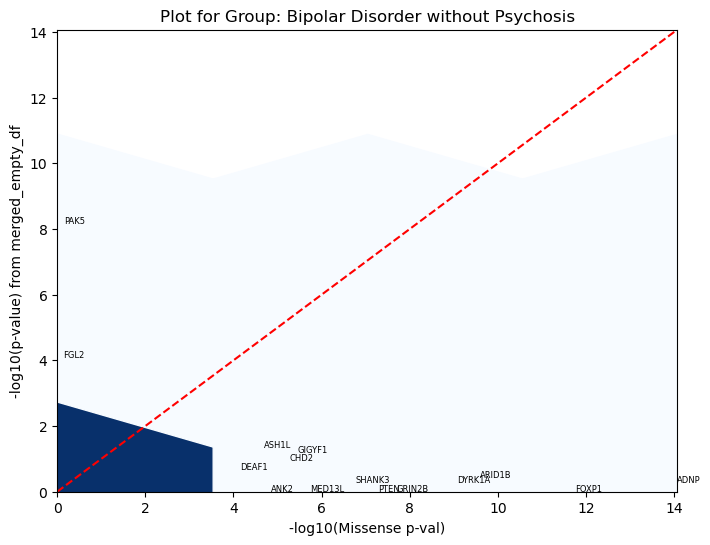

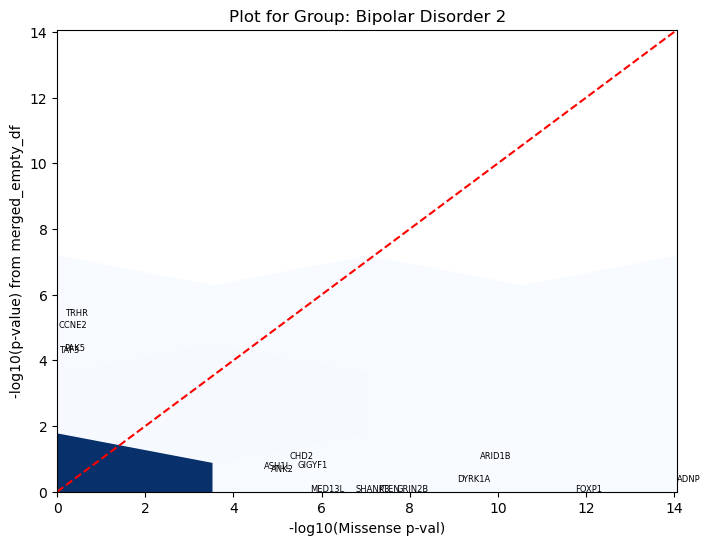

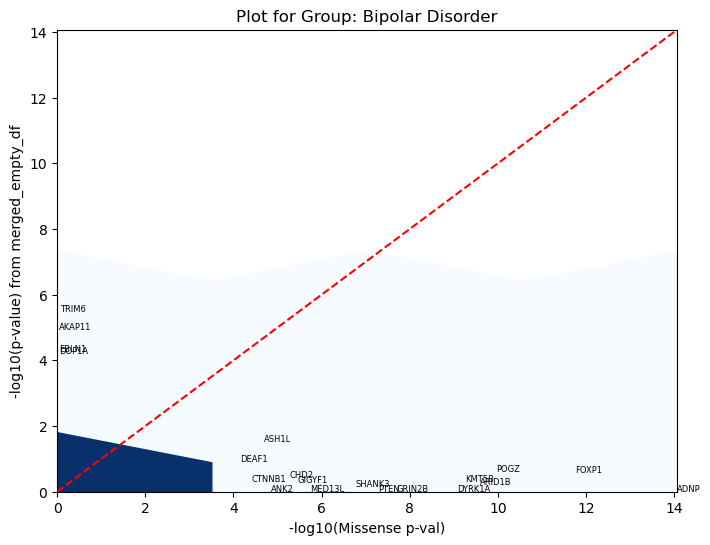

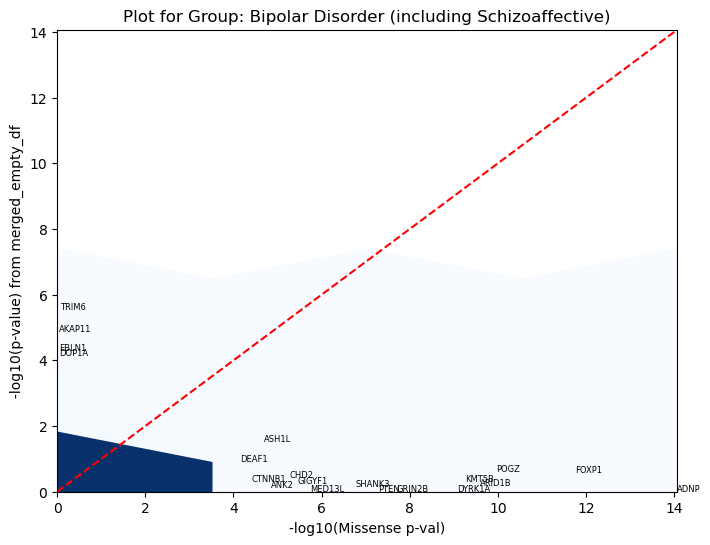

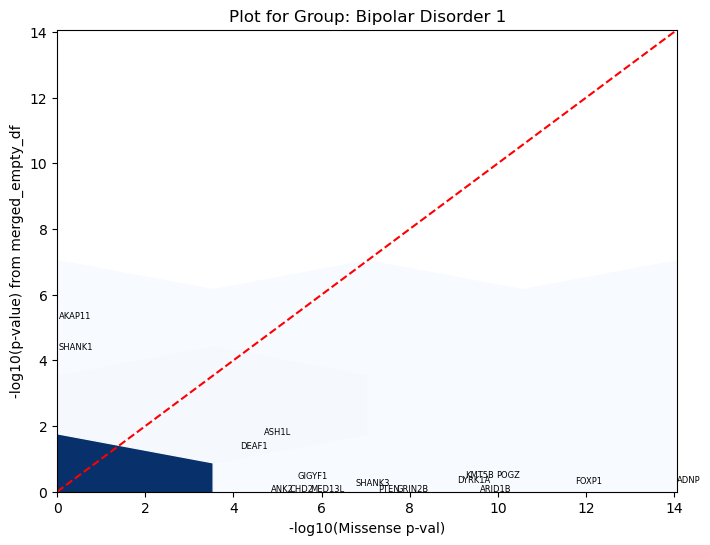

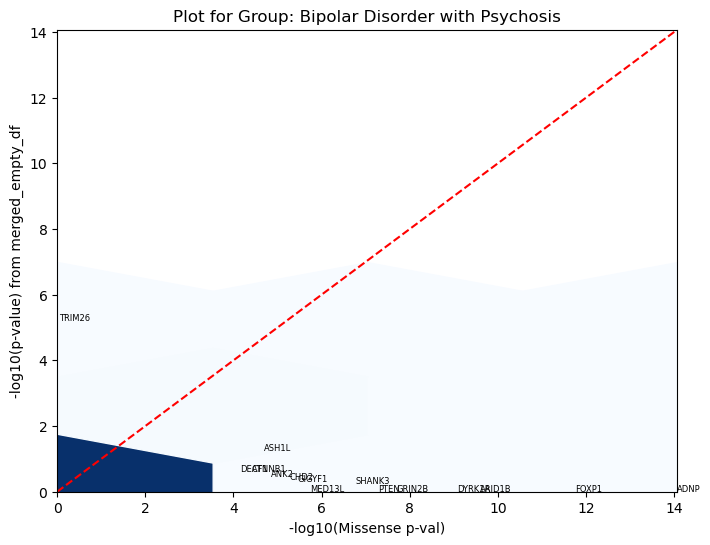

In [17]:
for group in significant_genes_df['group'].unique():
    file_pattern = data_path + "Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(significant_genes_df[significant_genes_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")